Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.
The SK-learn documentation on feature extraction will prove useful: http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.
As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [395]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [396]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
print(num_test,num_test/2)

# test, dev and train data/labels
test_data, test_labels = newsgroups_test.data[int(num_test/2):], newsgroups_test.target[int(num_test/2):]
dev_data, dev_labels = newsgroups_test.data[:int(num_test/2)], newsgroups_test.target[:int(num_test/2)]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print ('training label shape:', train_labels.shape)
print ('test label shape:', test_labels.shape)
print ('dev label shape:', dev_labels.shape)
print ('labels names:', newsgroups_train.target_names)

1353 676.5
training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [398]:
#printing first 5 training examples. It will show seq number, text and label for each example
def P1(num_examples=5):
    for i in range(0,num_examples):
        print("i=",i,"\nText = ",train_data[i],"\nLabel = ",train_labels[i])
    return;
P1()

i= 0 
Text =  Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych 
Label =  1
i= 1 
Text =  

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries. 
Label =  3
i= 2 
Tex

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [413]:
def P2():
    #CountVectorizer to fit and transform Train data
    vectorizer = CountVectorizer() 
    train_data_features = vectorizer.fit_transform(train_data)
    train_data_features=train_data_features.toarray()

    # Vocabulary size
    print("a.")
    print("size of the vocabulary = ",train_data_features.shape[1])

    #statistics of non zero features
    tot_nnz=np.count_nonzero(train_data_features)
    avg_nnz=tot_nnz/train_data_features.shape[0]
    frac_nnz=tot_nnz/(train_data_features.shape[0]*train_data_features.shape[1])

    print("average number of non-zero features per example = ",avg_nnz)
    print("fraction of non-zero features = ",frac_nnz)

    # 0th and last feature string after sorting alphabetically
    print("b.")
    featurenames=vectorizer.get_feature_names()
    print("0th feature string: ",featurenames[0])
    print("Last feature string: ",featurenames[-1])


    #Specifing vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. myvoc = ['atheism','graphics', 'space','religion',]
    newvectorizer = CountVectorizer(vocabulary=myvoc) 
    new_train_data_features = newvectorizer.fit_transform(train_data)
    new_train_data_features=new_train_data_features.toarray()

    #The shape of the training vectors
    print("c.")
    print("size of the training vector = ",new_train_data_features.shape)

    #statistics of non zero features
    new_tot_nnz=np.count_nonzero(new_train_data_features)
    new_avg_nnz=new_tot_nnz/new_train_data_features.shape[0]

    print("average number of non-zero features per example = ",new_avg_nnz)

    #bigram and trigram character features
    cvd= CountVectorizer(analyzer='char_wb',ngram_range=(1,2)) 
    cvd_features = cvd.fit_transform(train_data)

    cvd_features=cvd_features.toarray()
    print("d.")
    print("size of the vocabulary for bigram = ",cvd_features.shape[1])

    cvd= CountVectorizer(analyzer='char_wb',ngram_range=(1,3)) 
    cvd_features = cvd.fit_transform(train_data)
    print("size of the vocabulary for trigram = ",cvd_features.shape[1])

    #pruning words that appear in fewer than 10 documents
    cv1= CountVectorizer(min_df=10) 
    cv1_features = cv1.fit_transform(train_data)
    print("e.")
    print("size of the vocabulary after min_df=10 = ",cv1_features.shape[1])

    #fraction of the words in the dev data are missing from the vocabulary
    cv2=CountVectorizer()
    cv2_train=cv2.fit_transform(train_data)
    print(cv2_train.shape)
    cv2_dev=cv2.fit_transform(dev_data)
    print(cv2_dev.shape)
    print ("f.")
    print("Fraction of data missing: ",(cv2_train.shape[1]/cv2_dev.shape[1]-1))
    return;

    
    
P2()

a.
size of the vocabulary =  26879
average number of non-zero features per example =  96.70599803343165
fraction of non-zero features =  0.0035978272269590263
b.
0th feature string:  00
Last feature string:  zyxel
c.
size of the training vector =  (2034, 4)
average number of non-zero features per example =  0.0
d.
size of the vocabulary for bigram =  3167
size of the vocabulary for trigram =  29031
e.
size of the vocabulary after min_df=10 =  3064
(2034, 26879)
(676, 16246)
f.
Fraction of data missing:  0.6544995691247075


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [417]:
#inititating CountVectorizer
vectorizer = CountVectorizer() 
train_data_features = vectorizer.fit_transform(train_data)
dev_data_features= vectorizer.transform(dev_data)

#KNN
def KNClassifier(k,tX,tY,X):
    clfk = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    clfk.fit(tX,tY)
    y = clfk.predict(X)
    return y
    

def P3_knn(k_values):
    # finding accuracies for the dev set with different k values using the mini training set.
    for i in range(len(k_values)):
        preds=KNClassifier(k_values[i],train_data_features,train_labels,dev_data_features)
        print ("k=", k_values[i], "; accuracy:", np.mean(preds == dev_labels),
               "F1_score",metrics.f1_score(dev_labels,preds,average='weighted'))
    return;
 
# finding accuracies for the dev set with different k values using the mini training set.
k_values = [1,3,5,6,7,8,9,10]
P3_knn(k_values)

#MultinomialNB
clf_multi = MultinomialNB()   
clf_multi.fit(train_data_features, train_labels)
print ('MultinomialNB accuracy: %3.2f' %clf_multi.score(dev_data_features, dev_labels))

def P3_2(alphas):
    #creating instance of GridSearchCV with BernoulliNB and alphas
    clf_multi = GridSearchCV(MultinomialNB(), alphas)
    clf_multi.fit(train_data_features, train_labels)
    return clf_multi


alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P3_2(alphas)
print (nb.best_params_,nb.best_score_)

def P3_3(alphas):
    #creating instance of GridSearchCV with LogisticRegression and C
    clf_lr = GridSearchCV(LogisticRegression(penalty='l2'), C)
    clf_lr.fit(train_data_features, train_labels)
    return clf_lr


C = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
lr = P3_3(C)
print (lr.best_params_,lr.best_score_)

# calculating sum of square weights for different values of C
Cvals=[0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
for i in range(len(Cvals)):
    clf_lr= LogisticRegression(penalty='l2',C=Cvals[i])   
    clf_lr.fit(train_data_features, train_labels)
    y=clf_lr.predict(dev_data_features)
    print ('LR accuracy: %3.2f' %clf_lr.score(dev_data_features, dev_labels),
          'Sum of squared weight values:',(clf_lr.coef_**2).sum(axis=1),'C=',Cvals[i])
 

k= 1 ; accuracy: 0.383136094675 F1_score 0.380503001853
k= 3 ; accuracy: 0.414201183432 F1_score 0.408415022544
k= 5 ; accuracy: 0.423076923077 F1_score 0.428760723622
k= 6 ; accuracy: 0.442307692308 F1_score 0.446665054087
k= 7 ; accuracy: 0.443786982249 F1_score 0.450479100061
k= 8 ; accuracy: 0.440828402367 F1_score 0.446983581171
k= 9 ; accuracy: 0.430473372781 F1_score 0.43656661762
k= 10 ; accuracy: 0.421597633136 F1_score 0.427850290594
MultinomialNB accuracy: 0.78


C:\Users\rsshishi\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:664: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc)
C:\Users\rsshishi\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:664: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc)
C:\Users\rsshishi\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:664: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc)


{'alpha': 0.01} 0.828416912488
{'C': 0.5} 0.771386430678
LR accuracy: 0.43 Sum of squared weight values: [ 0.00031351  0.00061013  0.00038483  0.00034146] C= 1e-05
LR accuracy: 0.56 Sum of squared weight values: [ 0.00770175  0.0119412   0.00943508  0.00910284] C= 0.0001
LR accuracy: 0.64 Sum of squared weight values: [ 0.16509345  0.20095275  0.18067094  0.18724278] C= 0.001
LR accuracy: 0.68 Sum of squared weight values: [ 2.54154257  2.93970937  2.86246922  2.2500292 ] C= 0.01
LR accuracy: 0.70 Sum of squared weight values: [ 27.11729295  24.6588893   27.45950225  23.02184592] C= 0.1
LR accuracy: 0.71 Sum of squared weight values: [ 102.5845181    83.10703981   98.98510926   89.00577296] C= 0.5
LR accuracy: 0.70 Sum of squared weight values: [ 166.91117477  130.81078447  157.89322701  145.71786188] C= 1.0
LR accuracy: 0.70 Sum of squared weight values: [ 257.65355701  197.85819848  239.91646824  226.53776633] C= 2.0
LR accuracy: 0.69 Sum of squared weight values: [ 586.56046886  447

ANSWER: For KNN, the optimal value is 7. For MultinomialNB, the optimal alpha is 0.01 and for LR, the optimal C is 0.5. 

a. KNN doesnt work well becuase there are too many features

b. LR calculates the product of probability of each feature. so, the total product can be low for some low outliers and that can reduce the accuracy.

c. for LR, the sum of squared weight values increases with increasing C

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [421]:
def P4(arr, n=5):
    #initializing a zero matrix
    bb=np.zeros((4*n,4))
    i=0
    for i in range(0,4):
        #sort the array and find the five largest weights
        a1=arr[i,]
        ind=a1.ravel().argsort()[-5:]
        ind= (np.unravel_index(i, a1.shape) for i in ind)
        kk=-1
        #create 20X4 table
        for ii in ind:
            kk=kk+1
            for j in range(0,4):
                bb[kk+5*i,j]=arr[j,ii]
    return bb

#training a LR model
clf_lr=LogisticRegression()
clf_lr.fit(train_data_features,train_labels)
ss=P4(clf_lr.coef_)
print('20X4 table')
print(ss)

#training a LR model with bigram feature
clf_bg=CountVectorizer(ngram_range=(1,2))
train_feat_bg=clf_bg.fit_transform(train_data)
clf_lr_bg=LogisticRegression()
clf_lr_bg.fit(train_feat_bg,train_labels)
ss_bg=P4(clf_lr_bg.coef_)
print('20X4 table with bigram feature')
print(ss_bg)


20X4 table
[[ 0.93954473 -0.40968951 -0.44875277 -0.43465655]
 [ 0.95365121 -0.61674498 -0.7919459  -0.06459477]
 [ 0.98985703 -0.2208782  -0.34077526 -0.46321852]
 [ 1.03041464 -0.09676015 -0.31899837 -0.83494693]
 [ 1.12461512 -0.39781894 -0.42131043 -0.39599546]
 [ 0.14372862  0.97724751 -0.68123025 -0.48653545]
 [-0.35881227  1.12475534 -0.70201457 -0.37861042]
 [-0.33478332  1.26627638 -0.80669772 -0.62630154]
 [-0.58252754  1.34508372 -0.82495092 -0.46986072]
 [-0.7583622   1.93634443 -1.33610631 -0.76242895]
 [-0.35553153 -0.39338549  0.91937464 -0.38069548]
 [-0.47040742 -0.46537728  0.93644946 -0.33289687]
 [-0.57233068 -0.47937545  1.011648   -0.46754927]
 [-0.41395023 -0.67108258  1.22497536 -0.62890874]
 [-1.26005611 -1.31597909  2.16102869 -1.1707267 ]
 [-0.7935456  -0.07964521 -0.14910611  0.90470336]
 [-0.30876434 -0.27351966 -0.44815249  0.9127908 ]
 [-0.5332861  -0.10684323 -0.31606942  1.05463608]
 [-0.60783056 -0.418311   -0.27056517  1.11710703]
 [-0.7400304  -0.409

ANSWER: the top 5 largest weights for bigram features are smaller (~50%) than the unigram features.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [523]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
    #lowercasing
    lcase=s.lower()
    #removing special characters
    nstr = re.sub(r'[?|$|!|.|%|&]',r'',lcase)
    #changing the sequence of digits and _ to a single token
    lcase_noseq=re.sub("[0-9][0-9]*","1",nstr)
    lcase_noseq=re.sub("[_][_]*","_",lcase_noseq)   
  
    finals=lcase_noseq
    return finals

def P5():
    #empty preprocesses vectorizer
    empty_preprocessed_vectorizer = CountVectorizer(preprocessor=empty_preprocessor) 
    empty_train_data_features = empty_preprocessed_vectorizer.fit_transform(train_data)
    empty_dev_data_features = empty_preprocessed_vectorizer.transform(dev_data)

    #training a LR with empty preprocessed features
    clf_lr= LogisticRegression(C=0.01)   
    clf_lr.fit(empty_train_data_features, train_labels)
    y=clf_lr.predict(empty_dev_data_features)
    print ("accuracy with empty preprocessor:", np.mean(y == dev_labels),
                   "F1_score",metrics.f1_score(dev_labels,y,average='weighted'))
    
    #better preprocesses vectorizer
    better_preprocessed_vectorizer = CountVectorizer(preprocessor=better_preprocessor) 
    better_train_data_features = better_preprocessed_vectorizer.fit_transform(train_data)
    better_dev_data_features = better_preprocessed_vectorizer.transform(dev_data)

    #training a LR with better preprocessed features
    clf_lr_be= LogisticRegression(C=.02)   
    clf_lr_be.fit(better_train_data_features, train_labels)
    y_b=clf_lr_be.predict(better_dev_data_features)
    print ("accuracy with better preprocessor:", np.mean(y_b == dev_labels),
                   "F1_score",metrics.f1_score(dev_labels,y_b,average='weighted'))
    return;

    
P5()

accuracy with empty preprocessor: 0.668639053254 F1_score 0.651522033722
accuracy with better preprocessor: 0.67899408284 F1_score 0.665798326296


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".
Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

Number of non zero features =  1743
107516
Vocabulary size =  211 accuracy =  0.270710059172
Vocabulary size =  723 accuracy =  0.272189349112
Vocabulary size =  1094 accuracy =  0.272189349112
Vocabulary size =  2269 accuracy =  0.276627218935
Vocabulary size =  2444 accuracy =  0.278106508876
Vocabulary size =  5971 accuracy =  0.282544378698
Vocabulary size =  7581 accuracy =  0.282544378698
Vocabulary size =  10915 accuracy =  0.282544378698
Vocabulary size =  19030 accuracy =  0.282544378698
Vocabulary size =  23453 accuracy =  0.282544378698


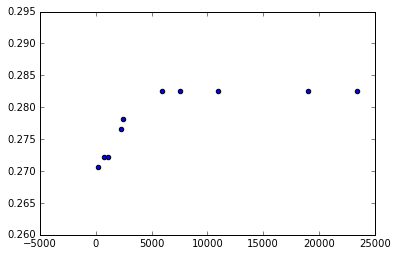

In [550]:
def P6():
    np.random.seed(0)
    # array of diff C vals
    Cvals=[0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 200.0, 500.0, 1000.0]
    
    #CountVectorizer
    vectorizer = CountVectorizer() 
    train_data_features = vectorizer.fit_transform(train_data)
    dev_data_features=vectorizer.transform(dev_data)
    
    #training LR with 'l1'
    clf_lr_l1= LogisticRegression(penalty='l1')   
    clf_lr_l1.fit(train_data_features, train_labels)    
    print("Number of non zero features = ",np.count_nonzero(clf_lr_l1.coef_))
    
    #training LR with 'l2'
    clf_lr_l2= LogisticRegression(penalty='l2')   
    clf_lr_l2.fit(train_data_features, train_labels)
    print(np.count_nonzero(clf_lr_l2.coef_))

    voc_size=[]
    accuracies=[]

    for i in range(len(Cvals)):
        cval=Cvals[i]
        #training LR with 'l1'
        clf_lr_l1= LogisticRegression(penalty='l1',tol=0.01,C=cval)   
        clf_lr_l1.fit(train_data_features, train_labels)
        
        #finding the features which has at least one non zeros weight
        sumcoef=sum(clf_lr_l1.coef_)
        nzi=sumcoef[np.abs(sumcoef)>0]
        
        #reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight 
        #and retrain a model using "l2"
        new_train_features=train_data_features[:,nzi]
        new_dev_features=dev_data_features[:,nzi]
       
        clf_lr_l2= LogisticRegression(penalty='l2',tol=0.01)   
        clf_lr_l2.fit(new_train_features, train_labels)
        voc_size.append(new_train_features.shape[1])
        accuracies.append(clf_lr_l2.score(new_dev_features,dev_labels))
        print("Vocabulary size = ",new_train_features.shape[1], "accuracy = ",clf_lr_l2.score(new_dev_features,dev_labels))
    
    #plotting accuracy vs vocabulary size
    plt.scatter(voc_size,accuracies)
    return;

P6()
    

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [533]:
def P7():
    #TfidfVectorizer
    clf_tfid=TfidfVectorizer()
    train_data_features_tfid=clf_tfid.fit_transform(train_data)
    dev_data_features_tfid=clf_tfid.transform(dev_data)

    #training a LR with C=100
    clf_lr_tfid= LogisticRegression(C=100)   
    clf_lr_tfid.fit(train_data_features_tfid, train_labels)
    pred_tfid=clf_lr_tfid.predict(dev_data_features_tfid)


    #predicted prob for each classes
    pred_prob=clf_lr_tfid.predict_proba(dev_data_features_tfid)

    #finding maximum prob for each sample
    max_pred_prob=np.amax(pred_prob,axis=1)

    #initializing a zero matrix for predicted prob of the correct label
    cor_lab_pred=np.zeros(len(dev_labels))

    #initializing a zero matrix for R, R =maximum predicted probability / predicted probability of the correct label
    R=np.zeros(len(dev_labels))
    for i in range(len(dev_labels)):
        #calculating R value for each sample
        cor_lab_pred[i]=pred_prob[i,dev_labels[i]]
        R[i]=max_pred_prob[i]/cor_lab_pred[i]

    #sorting R descending
    sortedR=sorted(range(len(R)),key=lambda x:R[x],reverse=True)

    #printing text, correct label and predicted label for three top R values
    for i in range (0,3):
        print("R=",R[sortedR[i]])
        print("correct Label is ",categories[dev_labels[sortedR[i]]], " predicted label is = ",categories[pred_tfid[sortedR[i]]])
        print(dev_data[sortedR[i]])
        
    return;

P7()

R= 929.358593528
correct Label is  sci.space  predicted label is =  talk.religion.misc
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in any way realize a profit
from the use of th

ANSWER: Tfidvectorizer predicted the first two texts as religious because of the presence of "Book of Mormon"
    
(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.